# Boolean Networks Cancer Mutation Analysis

## Scenario Analysis
Results and figures are shown here when you run the notebook.  
Answers can be found in this README.

### This code defines and analyzes Boolean networks for cell regulation by setting rules, simulating scenarios, identifying attractors, and visualizing results with plots.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
from itertools import product
from collections import Counter, defaultdict

# Helper class from the tutorial
class BooleanNetwork:
    def __init__(self, node_names):
        self.nodes = {name: 0 for name in node_names}
        self.rules = {}
        self.history = []
        self.graph = nx.DiGraph()
        self.graph.add_nodes_from(node_names)
    def add_rule(self, target_node, rule_function, rule_description=""):
        self.rules[target_node] = {'function': rule_function, 'description': rule_description}
    def set_state(self, **kwargs):
        for node, value in kwargs.items():
            if node in self.nodes:
                self.nodes[node] = int(bool(value))
    def get_state_vector(self):
        return [self.nodes[node] for node in sorted(self.nodes.keys())]
    def update_synchronous(self):
        new_state = {}
        for node in self.nodes:
            if node in self.rules:
                new_state[node] = int(self.rules[node]['function'](self.nodes))
            else:
                new_state[node] = self.nodes[node]
        self.nodes = new_state
        self.history.append(self.get_state_vector())
    def simulate(self, steps=15, record_history=True):
        if record_history:
            self.history = [self.get_state_vector()]
        for step in range(steps):
            self.update_synchronous()
            if len(self.history) >= 2 and self.history[-1] == self.history[-2]:
                break
        return np.array(self.history)

# Helper function to set up network rules
def setup_network_rules(network, mutation=None):
    """Applies rules to a network, including an optional mutation."""
    # Base rules
    network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
    network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
    network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
    network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT s['p53'])")
    network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
    network.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
    network.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT s['p53'])")
    network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")
    
    # Apply mutation if specified
    if mutation == 'A':
        network.add_rule('p53', lambda s: False, "p53 = BROKEN (always OFF)")
    elif mutation == 'B':
        network.add_rule('MYC', lambda s: True, "MYC = AMPLIFIED (always ON)")
    elif mutation == 'C':
        network.add_rule('MDM2', lambda s: True, "MDM2 = OVEREXPRESSED (always ON)")
    elif mutation == 'D':
        network.add_rule('p21', lambda s: False, "p21 = BROKEN (always OFF)")
    return network

# Helper function to print rules
def print_network_rules(network, title):
    """Prints the rules of a given network in a sorted order."""
    print(f"\n--- {title} ---")
    node_names_sorted = sorted(network.rules.keys())
    for node in node_names_sorted:
        rule_info = network.rules[node]
        print(f"  {rule_info['description']}")
    print("-------------------------------------------\n")


# --- Analysis Functions ---

def analyze_scenarios(network, scenarios, node_names, network_name):
    """Runs the three specific scenarios and creates a visualization."""
    print("\n### 1. Scenario Analysis ###\n")
    results = {}
    for s, initial_state in scenarios.items():
        network.set_state(**initial_state)
        trajectory = network.simulate(steps=12)
        results[s] = trajectory

    fig, axes = plt.subplots(1, len(results), figsize=(18, 6), sharey=True)
    fig.suptitle(f'{network_name}: Scenario Dynamics', fontsize=16, fontweight='bold', y=1.02)
    for i, (scenario_name, trajectory) in enumerate(results.items()):
        ax = axes[i]
        trajectory_matrix = trajectory.T
        ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')
        ax.set_title(scenario_name, fontweight='bold', fontsize=12)
        ax.set_xlabel('Time Steps', fontsize=10)
        if i == 0:
            ax.set_ylabel('Network Nodes', fontsize=10)
        ax.set_yticks(range(len(node_names)))
        ax.set_yticklabels(node_names, fontsize=9)
        for t in range(trajectory.shape[0]):
            for n in range(len(node_names)):
                color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
                ax.text(t, n, int(trajectory_matrix[n, t]), ha="center", va="center", color=color, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.98])

def analyze_attractors(network, node_names, network_name):
    """Finds all attractors, their basins, and calculates the cancer-like percentage."""
    print("\n### 2. Attractor & Basin Analysis ###\n")
    
    attractors = []
    basin_data = defaultdict(list)
    all_states = list(product([0, 1], repeat=len(node_names)))

    for initial_state_vec in all_states:
        state_dict = {node_names[i]: initial_state_vec[i] for i in range(len(node_names))}
        network.set_state(**state_dict)
        trajectory = network.simulate(record_history=True)
        final_state = tuple(trajectory[-1])
        if final_state not in attractors:
            attractors.append(final_state)
        basin_data[final_state].append(initial_state_vec)

    dna_damage_idx = node_names.index('DNA_damage')
    growth_idx = node_names.index('Growth')
    total_cancer_states = 0

    print(f"Found {len(attractors)} attractors for this network.")
    for attractor in attractors:
        is_cancer = (attractor[growth_idx] == 1 and attractor[dna_damage_idx] == 1)
        if is_cancer:
            total_cancer_states += len(basin_data[attractor])

    cancer_percentage = (total_cancer_states / len(all_states)) * 100
    print(f"\n❓ Percentage of initial states leading to a cancer-like attractor: {cancer_percentage:.1f}%\n")

    fig_att, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, max(4, len(attractors)*0.8)))
    fig_att.suptitle(f'{network_name}: Attractor & Basin Analysis', fontsize=16, fontweight='bold', y=1.02)
    
    attractor_matrix = np.array(attractors)
    sns.heatmap(attractor_matrix, ax=ax1, xticklabels=node_names,
                yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                cmap='RdYlBu_r', annot=True, fmt='d', linewidths=0.5)
    ax1.set_title('Attractor States', fontweight='bold')

    basin_sizes = [len(basin_data[att]) for att in attractors]
    basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
    ax2.pie(basin_sizes, labels=basin_labels, autopct='%1.1f%%', startangle=90,
            colors=plt.cm.Set3(np.linspace(0, 1, len(attractors))))
    ax2.set_title('Basin of Attraction Sizes', fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.98])

### This block defines the nodes and scenarios, sets up normal and mutated networks, runs scenario and attractor analyses for each, and displays all resulting plots.


Analyzing Normal (Wild-Type) Network

--- Final Rules for Normal (Wild-Type) Network ---
  CDK2 = MYC AND (NOT p21) AND (NOT s['p53'])
  DNA_damage = INPUT (constant)
  Death = p53 AND DNA_damage AND (NOT Growth)
  Growth = CDK2 AND MYC AND (NOT s['p53'])
  MDM2 = MYC
  MYC = (NOT p53) AND (NOT p21)
  p21 = p53
  p53 = DNA_damage AND (NOT MDM2)
-------------------------------------------


### 1. Scenario Analysis ###


### 2. Attractor & Basin Analysis ###

Found 3 attractors for this network.

❓ Percentage of initial states leading to a cancer-like attractor: 3.1%


Analyzing Mutation A: p53 Knockout

--- Final Rules for Mutation A: p53 Knockout ---
  CDK2 = MYC AND (NOT p21) AND (NOT s['p53'])
  DNA_damage = INPUT (constant)
  Death = p53 AND DNA_damage AND (NOT Growth)
  Growth = CDK2 AND MYC AND (NOT s['p53'])
  MDM2 = MYC
  MYC = (NOT p53) AND (NOT p21)
  p21 = p53
  p53 = BROKEN (always OFF)
-------------------------------------------


### 1. Scenario Analysis ###


### 2. Att

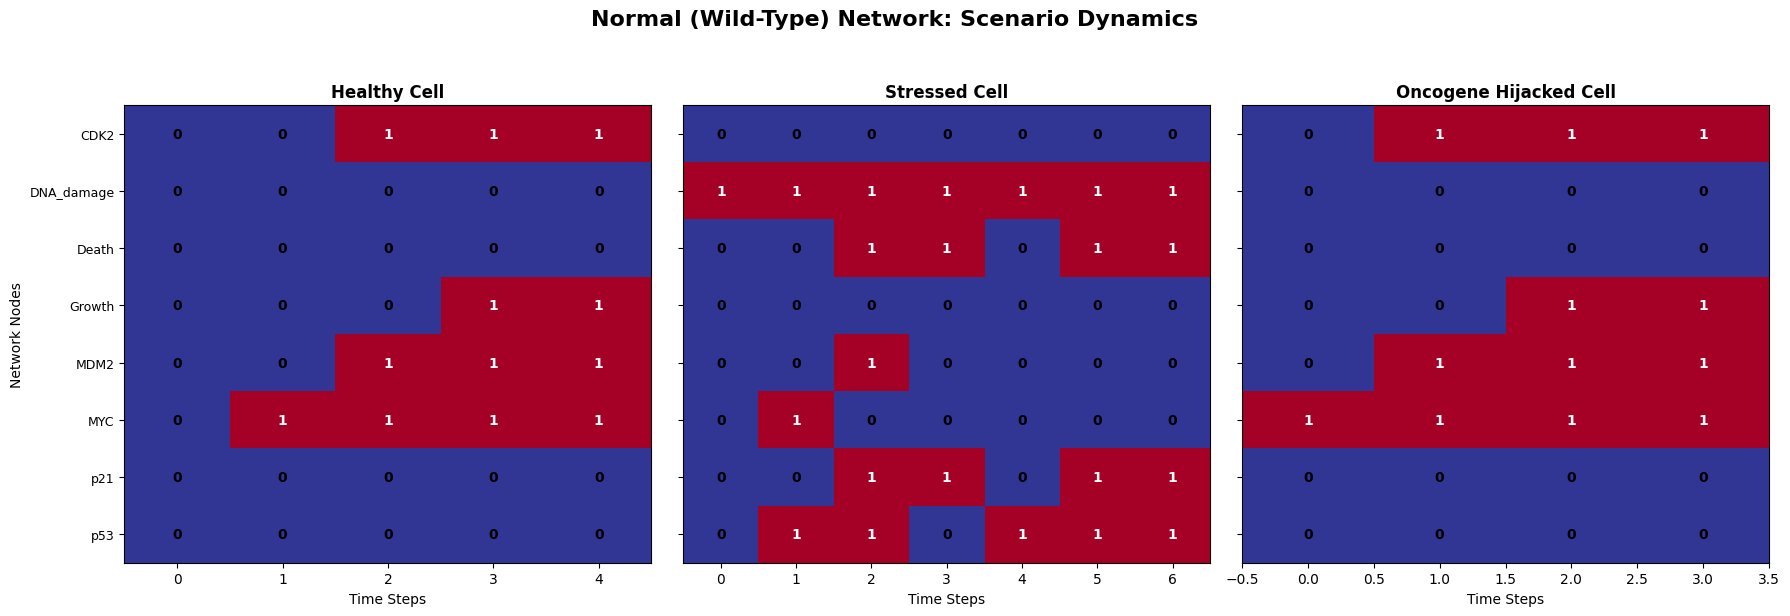

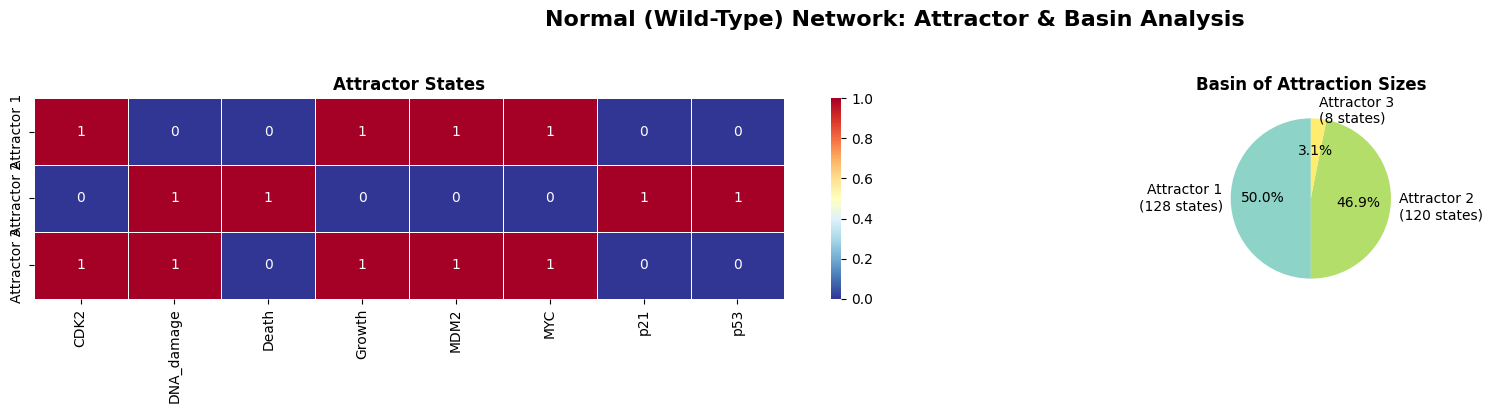

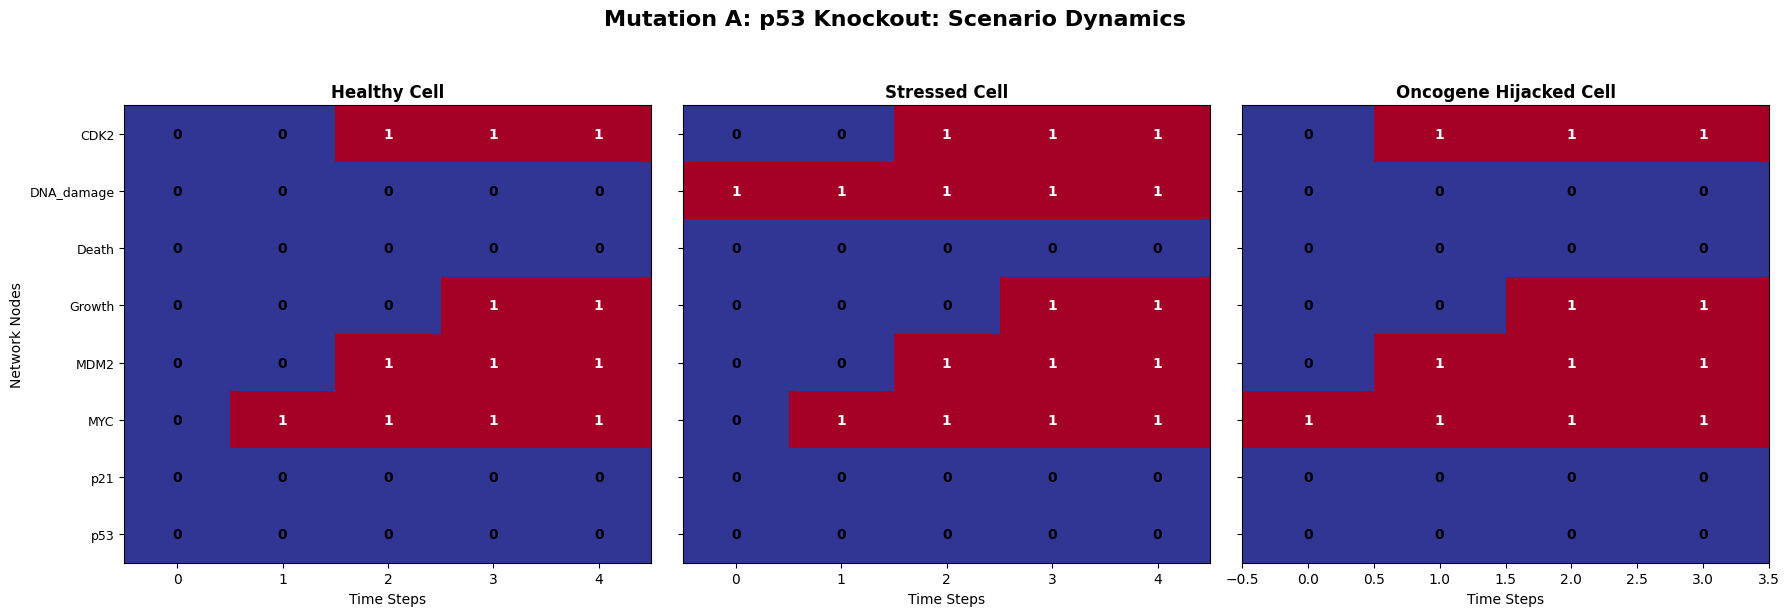

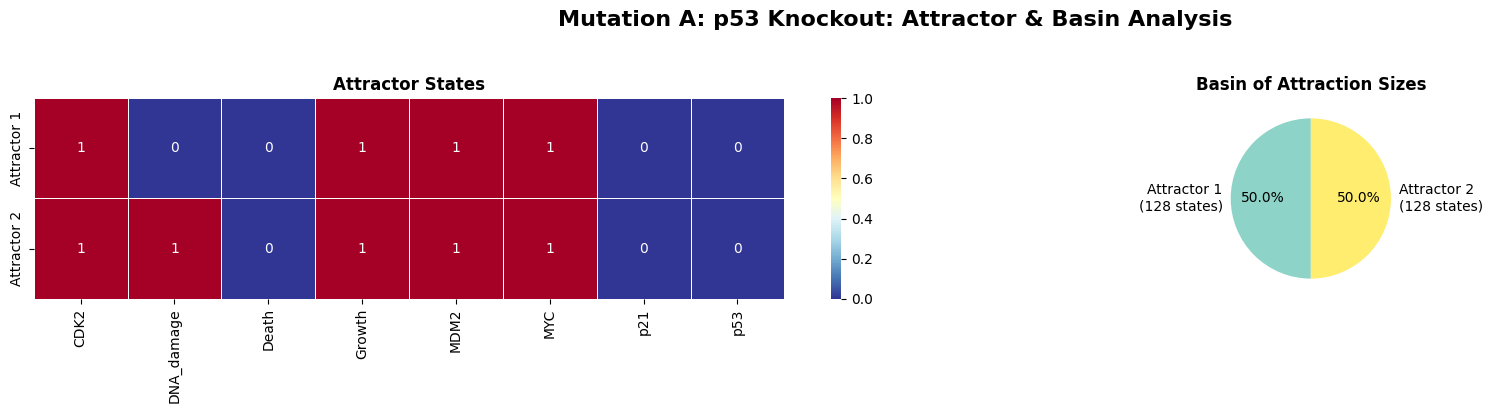

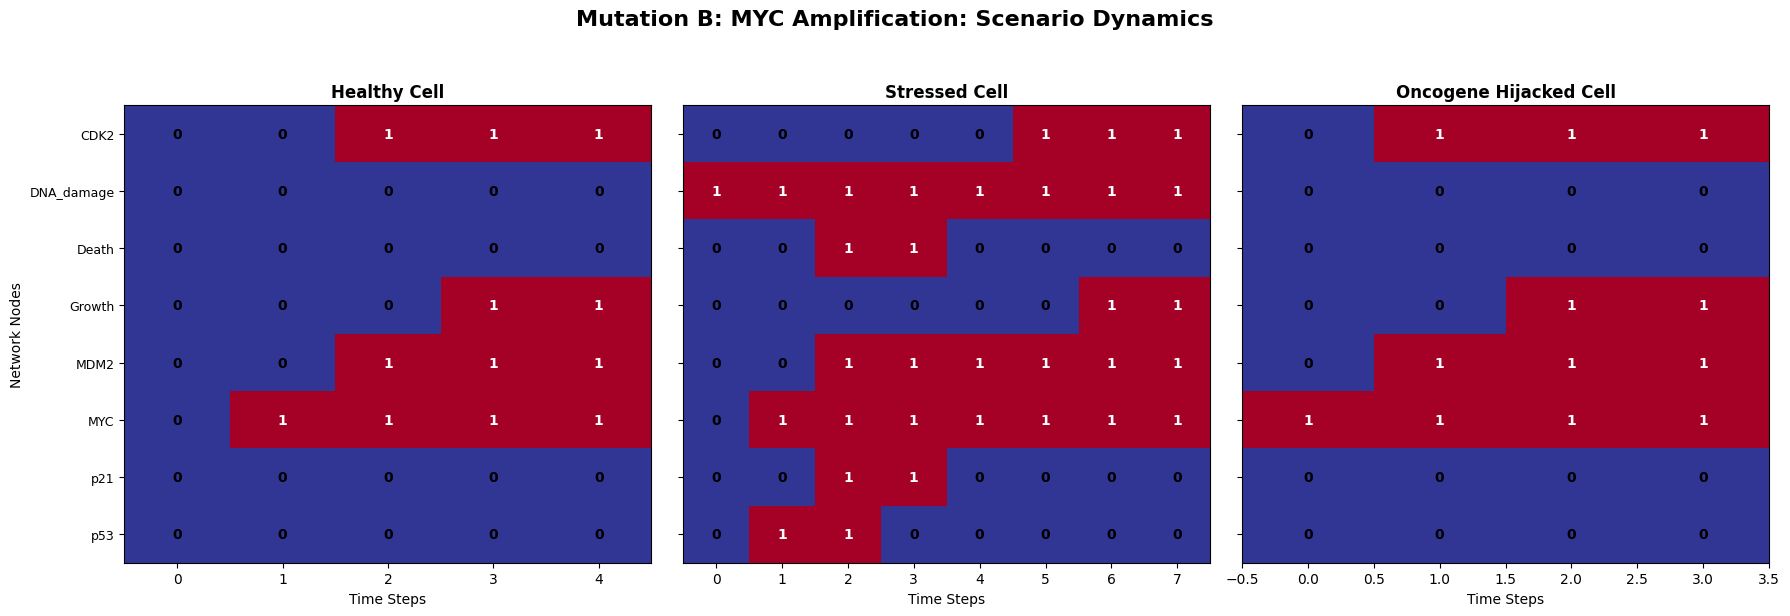

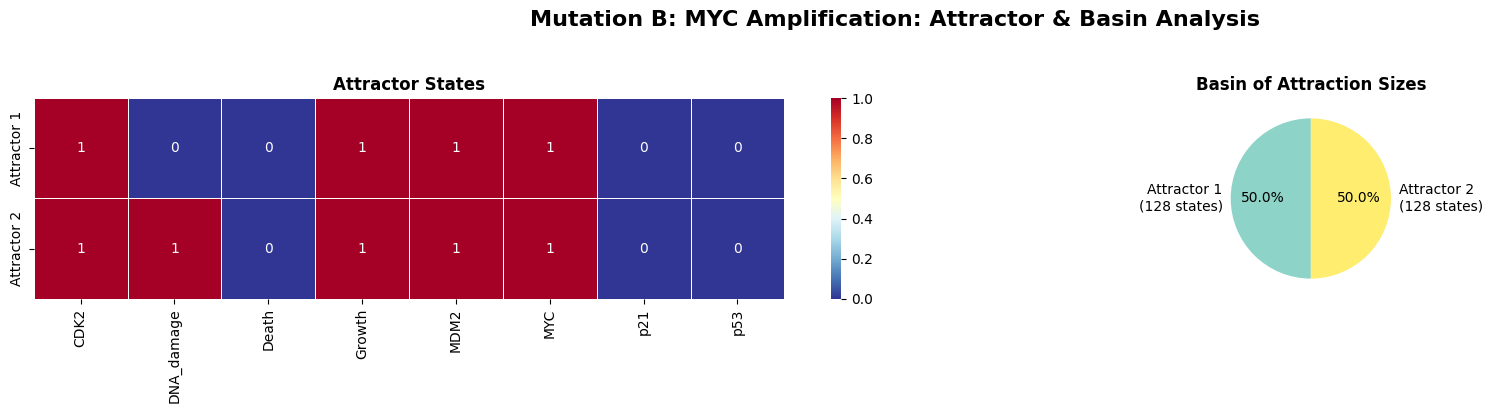

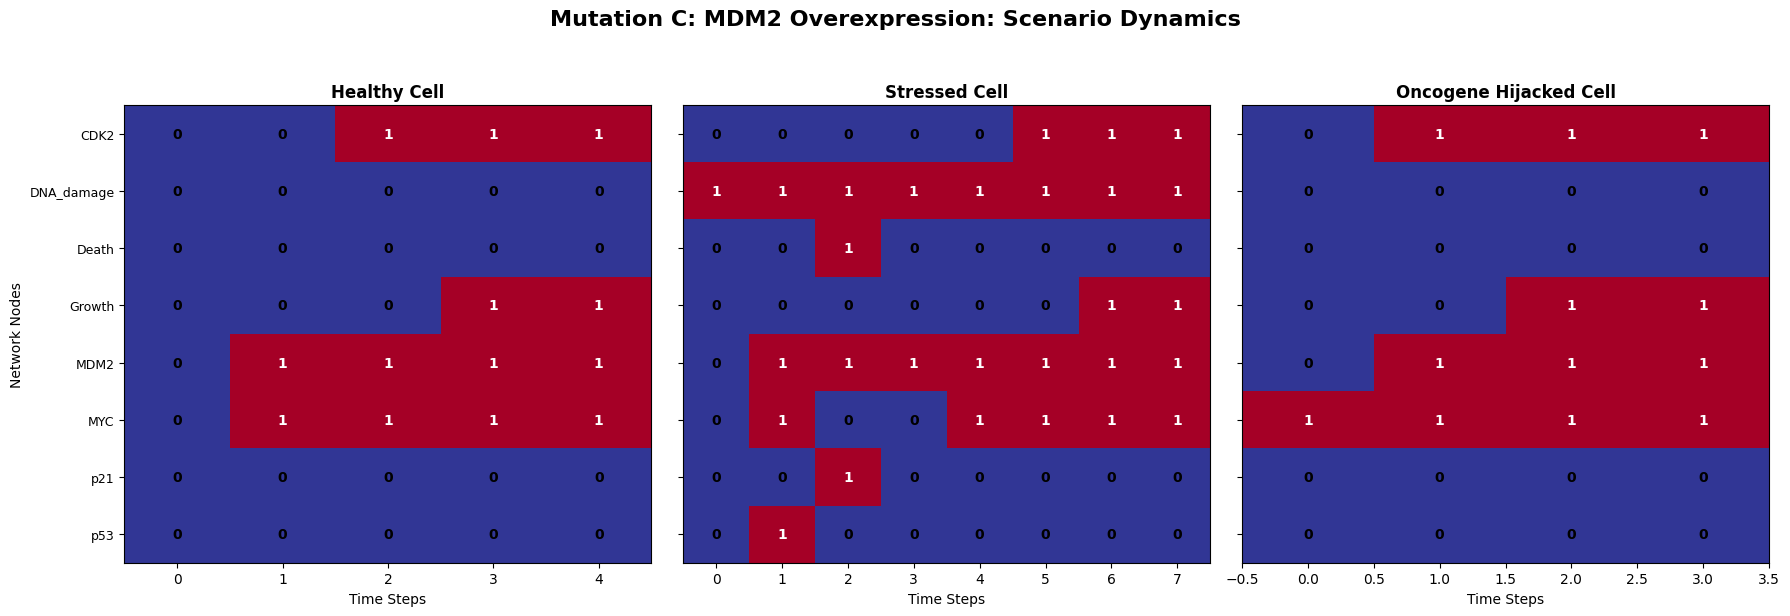

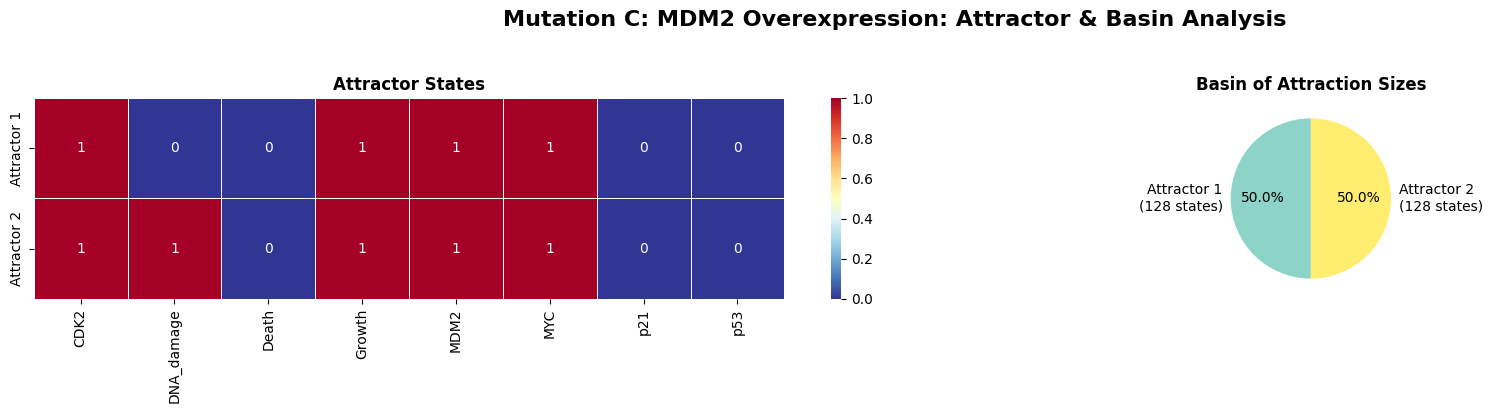

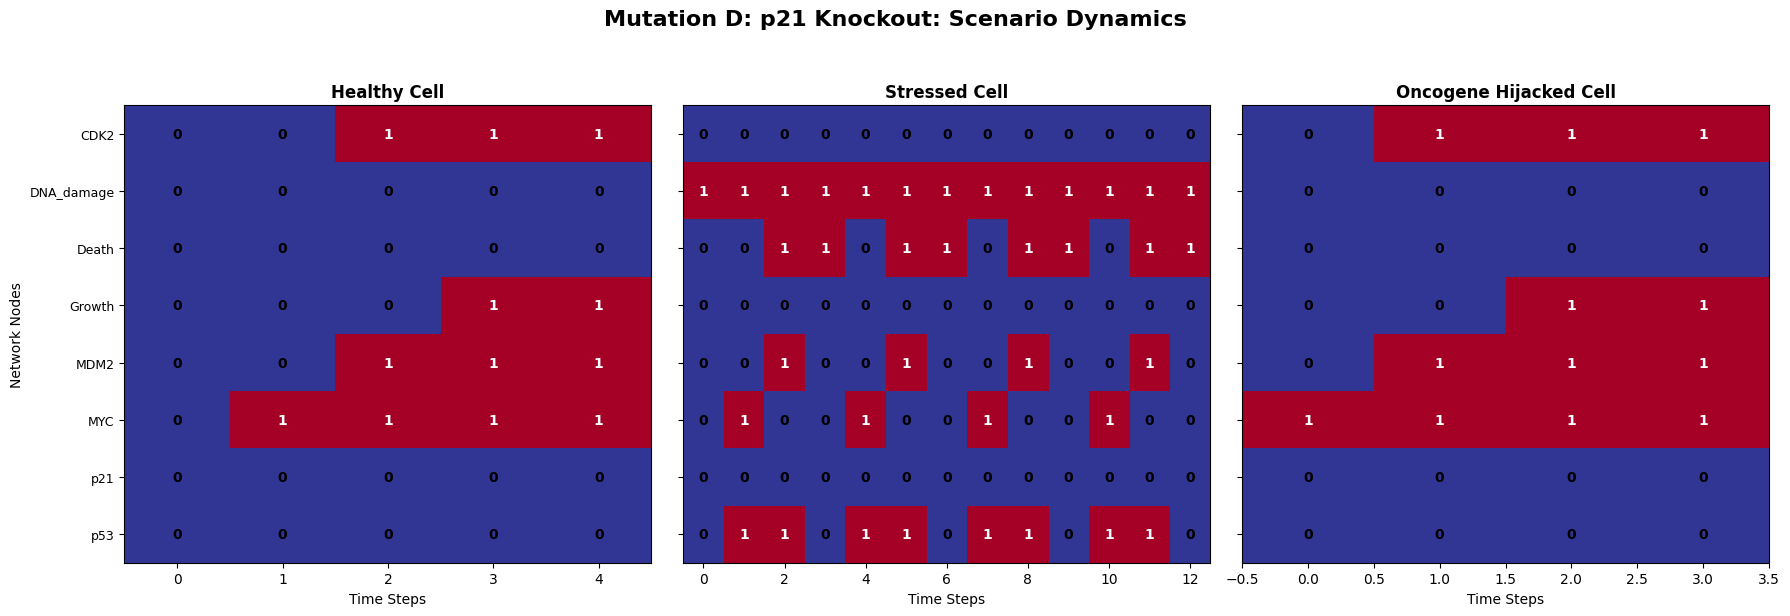

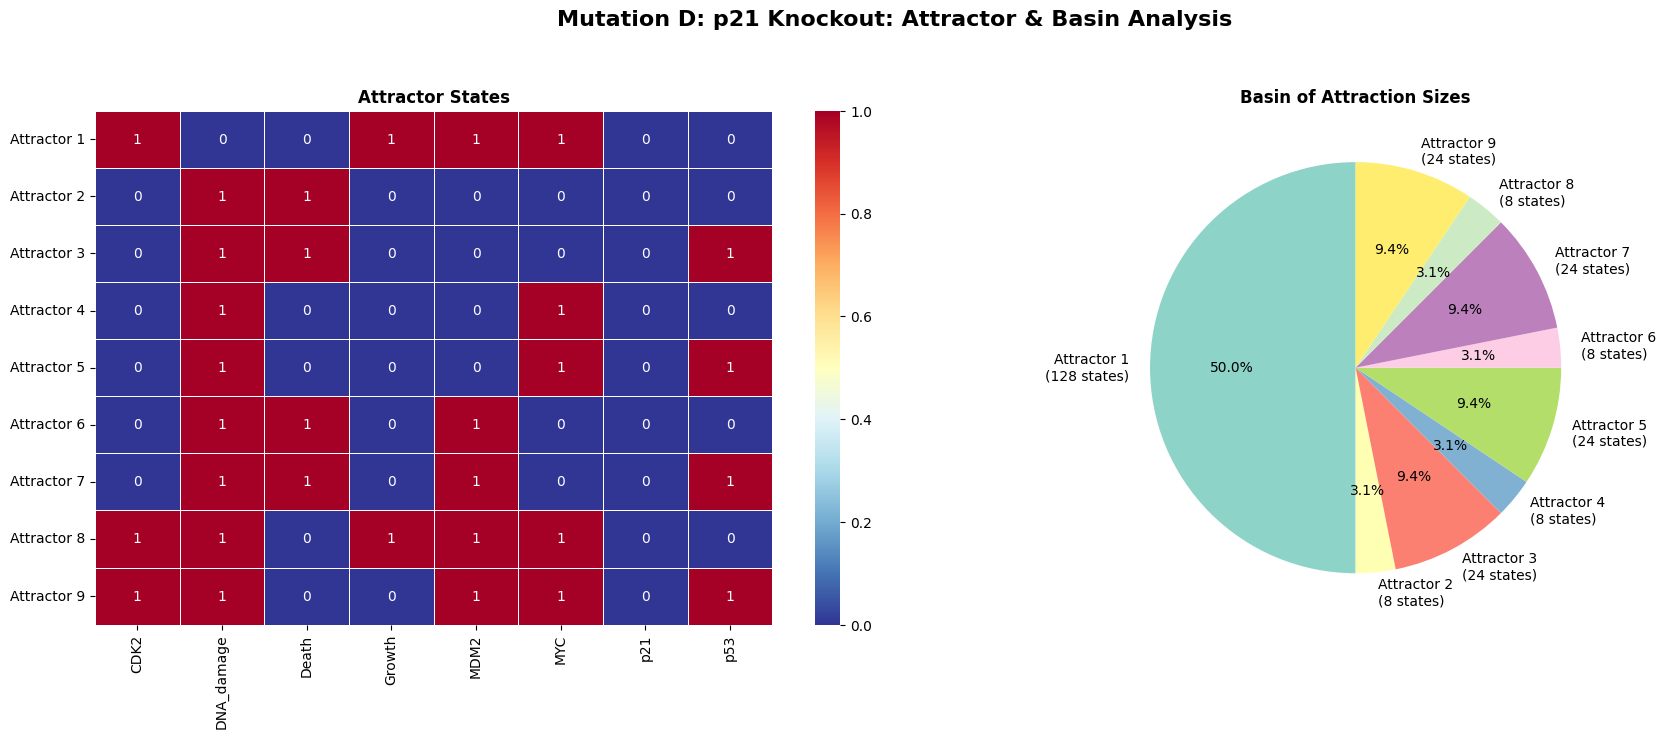

In [2]:
# 1. Define Nodes and Scenarios
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
node_names = sorted(nodes)
scenarios = {
    'Healthy Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Stressed Cell': {'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Oncogene Hijacked Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}
networks_to_analyze = {
    "Normal (Wild-Type) Network": None,
    "Mutation A: p53 Knockout": "A",
    "Mutation B: MYC Amplification": "B",
    "Mutation C: MDM2 Overexpression": "C",
    "Mutation D: p21 Knockout": "D"
}

# 2. Loop through each network and run all analyses
for name, mutation_key in networks_to_analyze.items():
    print(f"\n{'='*80}\nAnalyzing {name}\n{'='*80}")
    
    # --- Setup the specific network ---
    network = BooleanNetwork(node_names)
    network = setup_network_rules(network, mutation=mutation_key)
    
    # --- Print the rules for the current network ---
    print_network_rules(network, f"Final Rules for {name}")

    # --- Run Analyses ---
    analyze_scenarios(network, scenarios, node_names, name)
    analyze_attractors(network, node_names, name)

# Finally, show all the generated plots
plt.show()